# Classification Project- Peer to Peer Lending- Bondora
---

**This project was made with the cooperation of Orel Mishael as part of Data Science course assignments**

In this project we tried to predict which loans will be repaid (or not) in a Peer-to-Peer model - Bondora's site.

beacuse we saw early-on that the site's labeling of "Repaid" and "Late" was questionable just like it's promise of earnings

(many records had debts, many were long over-dues before finally being paid, and some had strange debt write-offs which were not explaind , but all still were labeld as "Repaid")

we decided to take matters into our hands and so this project became a **relabeling and predicting project**

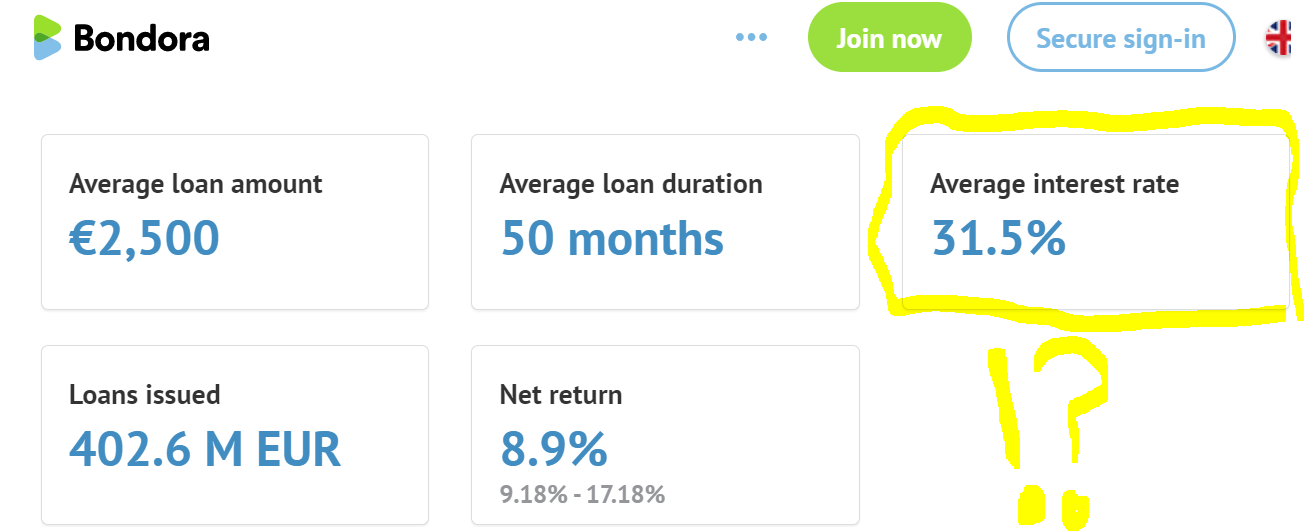

In [ ]:
from sklearn import set_config
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import roc_curve as roc

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
import warnings
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings('ignore')

set_config(display='diagram')



we are loading two tables- loans and repayments (df)

loans has many columns (mostly regarding the target, not the X) -- only 13 are used as features!

In [ ]:

path= r'../input/loansdata/RepaymentsData.csv'
path2= r'../input/loansdata/LoanData.csv'


df= pd.read_csv(path, parse_dates=[2], infer_datetime_format=True)

loans= pd.read_csv(path2,index_col=1, parse_dates=[11,13]\
                   , infer_datetime_format=True)

loans.shape 


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
loans[['Gender','Age','IncomeTotal','LoanDuration','Amount'
       ,'LiabilitiesTotal']].describe()

lonas basic filtering : age, income, liabilities.  also not using loans after covid-19 pandemic started

loans that have a "Current" status, have not been resolved yet so are not usable in our case.

In [ ]:

# loans basic filtering: 

#amount bigger than 200:
loans['LoanDate']= pd.to_datetime(loans['LoanDate'])
loans= loans[ (loans['Amount']>=200)  & (loans['LoanDate']>'2011-03-01') & (loans['LoanDate']<'2020-01-01')]

# loans per user name up to 5:
loans_per_user= loans.groupby('UserName')['LoanNumber'].count()
loans_per_user.value_counts().plot(kind='bar')
lons_per_user_filter= loans_per_user[loans_per_user<=5]

#age 18+:
loans= loans[loans['UserName'].isin(lons_per_user_filter.index)]
loans= loans[loans['Age']>=18]

#eliminate current status
loans = loans[loans['Status']!='Current']

#incomeTotal
loans = loans[loans['IncomeTotal']<30000]

#LiabilitesTotal
loans = loans[loans['LiabilitiesTotal']<15000]

plt.title("number of loans taken vs. amount of users");


In [ ]:
# data cleaning and uniting rare categories:

# (uniting categories should help with tree regularization)

# gender - change to names. 0='man', 1='woman', 2='unknown'
loans=loans.replace(
{'Gender' : { 0.0 : 'male', 1.0 : 'woman', 2.0: 'unknown' }}) 
     
# country : drop slovakia - only 300 records almost all late
loans= loans[loans['Country'] !='SK']

# education : unite 4,5 as  higher , unite 1 and 3 as lower/technical
loans= loans[loans['Education']>0] # remove nulls (very few)
loans=loans.replace(
{'Education' : { 2.0 : 'basic', 4.0 : 'higher', 5.0: 'higher'
            ,1.0:'lower/technical', 3.0:'lower/technical'}}) 

# loan_duration: add feature : two years or less (~8,000 values)
loans['under_2years_loan']= np.where(loans['LoanDuration']<=24,'True','False')

# loan hour sign - add feature -- before 8 AM (more chance for Late)
loans['sign_after_7AM']= np.where(loans['ApplicationSignedHour']>7, '+', '-')

# employment status -add feature - filled or didn't filled (more chance for Late)?
loans['filled_details'] = np.where(loans['EmploymentStatus']> 0 , 'yes', 'no')

# 'EmploymentDurationCurrentEmployer': unite rare : 2years, 3years, 4years.  unite trial to 1 year.   5 years or more, others
loans=loans.replace(
{'EmploymentDurationCurrentEmployer' : { 'UpTo1Year' : 'trial to 1 year', 
                                        'UpTo2Years' : '2 to 4 years'
                                        , 'UpTo3Years' : '2 to 4 years' , 
                                        'UpTo4Years':'2 to 4 years'
                                        , 'TrialPeriod':'trial to 1 year' 
                                        ,'UpTo5Years':'5 years or more', 
                                        'MoreThan5Years':'5 years or more'
                                        ,'Other':'Others', 'Retiree':'Others'}})

# HomeOwnershipType : unite 1 and 6 to 9 (ownership) drop -1, 0 (homeless)
loans= loans[loans['HomeOwnershipType']>0]
loans=loans.replace(
{'HomeOwnershipType' : { 1.0 : 'owner or partly', 6.0 : 'owner or partly',
                        7.0 : 'owner or partly' , 8.0: 'owner or partly',
                        9.0: 'owner or partly'
                                        ,2.0:'tenant or others', 3.0:'tenant or others',
                        4.0:'tenant or others', 5.0:'tenant or others', 10.0:'tenant or others'}}) 

#rating- : unite the rare ratings- A AA B to C as prime. replace nulls with D (medium)
loans['Rating'].isnull().sum()# 648 nulls (less than 1%)
loans['Rating']= loans['Rating'].fillna('D')
loans=loans.replace(
{'Rating' : { 'AA' : 'prime', 'A' : 'prime', 'B': 'prime', 'C': 'prime' 
            ,'D':'medium', 'E':'subprime', 'F':'subprime', 'HR': 'subprime'}}) 


#credit in Finland :['CreditScoreFiAsiakasTietoRiskGrade'] :

# nulls are very few and ignored

loans=loans.rename(columns={'CreditScoreFiAsiakasTietoRiskGrade':'credit_finland'})
loans=loans.replace({'credit_finland':
{ 'RL1' : 11, 'RL2' : 12, 'RL3': 13, 'RL4': 14 ,'RL5':15}}) 

loans['credit_finland']= loans['credit_finland'].fillna(0) # not from finland 
loans['credit_finland']= loans['credit_finland'].astype('int')

#  drop 7,8,14,15:
loans= loans[  
             (loans['credit_finland']!=7) &
             (loans['credit_finland']!=8) &
             (loans['credit_finland']!=14) &
             (loans['credit_finland']!=15) 
             ]
#unite:
loans=loans.replace({'credit_finland':
{ 1 : 'fin_prime', 2 : 'fin_prime', 12 : 'fin_prime', 13: 'fin_prime',
 11: 'fin_prime',
 3:'fin_prime',
 4:'fin_sub', 5:'fin_sub', 6:'fin_sub', 0:'not_finland'}}) 



#credit in spain : drop AA D AAA, nulss will be imputed later on with knn classifier:
loans= loans[ (loans['CreditScoreEsEquifaxRisk']!='AA') &
             (loans['CreditScoreEsEquifaxRisk']!='AAA') &
             (loans['CreditScoreEsEquifaxRisk']!='D') ]


loans= loans.rename(columns={"CreditScoreEsEquifaxRisk": "credit_spain"})
loans['credit_spain']= np.where((loans['Country']!='ES'), "not_spain",
                                                    loans['credit_spain'] )


#credit in estonia -  : fill na with 1000
# devide to prime and sub
loans['CreditScoreEeMini']= np.where((loans['Country']=='EE')& (loans['CreditScoreEeMini'].isnull()),
                                     1000.0, loans['CreditScoreEeMini'])

loans['CreditScoreEeMini']= loans['CreditScoreEeMini'].fillna('not_estonia')                                     
loans['credit_estonia']= np.where(loans['CreditScoreEeMini']==1000.0,'est_prime',
                            np.where (loans['CreditScoreEeMini']!='not_estonia', 'est_sub',
                                      loans['CreditScoreEeMini']))


using the repayment table:

the repayments table describes every transcations that occured in every loan that appears in the loans table

this table will be used for relabeling with the help of the following steps:
1. data enrichment of repayment table with loans table info (adding columns like amount and loan duration)
2. adding calaulated columns (days passed, monthly payment, overall return)
3. null imputing of the monthly payment column with the calculated one (pmt funcion)
3. aggregating and labeling every transcations with the 3 transformers below 


In [ ]:


#filter payments table according to loans table:
df= df[df['loan_id'].isin(loans.index) ]

print(loans['Status'].value_counts())

#order by loan_id:
df= df.sort_values(by=['loan_id','Date']).reset_index(drop=True)

# calculate days passed between every payment:
df['date2']= df['Date'].shift(periods=1).where(df['loan_id'].eq(df['loan_id'].shift()))

df['days_passed']= df['Date']-df['date2']

# turn days passed to numeric
df['days_numeric']= df['days_passed'].astype('str').str.extract('(\d+)').astype('float')

# calculat days passed from FirstPaymentDate:
df= df.join(loans['FirstPaymentDate'],on= df['loan_id'])
df= df.join(loans['LoanDate'] ,on= df['loan_id'])

df['days_first_pay']= (df['LoanDate']-df['FirstPaymentDate'])\
                .astype('str').str.extract('(\d+)').astype('float')

# add status column :
df= df.join(loans['Status'], on= df['loan_id'])

# add amount column (total loan to pay):
df= df.join(loans['Amount'], on= df['loan_id'])

# add Monthylypayment
df= df.join(loans['MonthlyPayment'], on= df['loan_id'])

# add loan duration
df= df.join(loans['LoanDuration'], on= df['loan_id'])

#add claculated monthly payment with pmt function:
loans['calc_month_payment']= -1* (np.pmt(loans['Interest']/1200, 
                                         loans['LoanDuration'], loans['Amount']))

df= df.join(loans['calc_month_payment'], on= df['loan_id'])

# add total monthly payment :
df['total_paid_this_month']= df['InterestRepayment']+ df['PrincipalRepayment']\
                                                    +df['LateFeesRepayment']

# fill na in monthly payment with calculated payment:
df['MonthlyPayment']= df['MonthlyPayment'].combine_first(df['calc_month_payment'])

# replce 0 payment with calculate payment:
df['MonthlyPayment']= np.where(df['MonthlyPayment']==0, df['calc_month_payment'],
                               df['MonthlyPayment'])

# calculate monthly return precantage:
df['return_prec']=100*(df['total_paid_this_month']/df['MonthlyPayment'])

# add overall return as column:
df['overall_paid']= df['loan_id'].map(df.groupby('loan_id')['total_paid_this_month'].sum())


   **y Transformers scheme**
   
loans -> X_test , y_test  (split by time)
                                                                                            
    loans--> df + columns-->df_paid-> 
                                    ->df_paid_train-->_paid_test-->y_test_new         
                            X_train->  
                                                                       

explaining this scheme :
1. splitting loans to test and train to avoid data leakage and to create a time series data-set format
2. choosing the transcations in the repayment table that appear in the loans table
3. creating "df_paid_train" table which  contains the transactions that appear in the X_train part of loans
4. fitting the transformers below to "df_paid_train" (this will be the X in our transformers)
5. transforming df_paid_test ,which relabels the loans it contains.
6. after transforming , df_paid_test is used to relabel y_test  (and df_paid_train is used to relabel y_train)

---
to decided if a loan is going to be relabeled "late", first we will label the repayments in the following cases :

    1-  they were repaid too late (relative to norm..) -- see transformer 1
    
    2-  the payments are too low (also relatively)  --- see transformer 2
    

then the  whole loan itself will be labeled "late" if:        
    
    3-  the amount of payments that were late or incomplete is bigger than the allowed amount --- see transformer 3
    
    4-  the total payment is lower than total loan taken

---

1. **DurationCat transformer**

this transformer adds a column :

'late_payment_cat': add a category for each duration of payment calculated with the limits (based on average and std of loans)


In [ ]:

class DurationCat  (TransformerMixin, BaseEstimator):  # TransformerMixin needed for fit_transform
    
    def __init__(self):
        super().__init__() # needed for heriatance
        pass
        
    def fit (self ,X ,y= None):
        
        self.df_paid_lates= X[(X['days_numeric']<183)&
                                              (X['days_numeric']>27)]
        self.late_avg = self.df_paid_lates.groupby(['duration_type'])\
                                        ['days_numeric'].mean().mean()
        self.late_std = self.df_paid_lates.groupby(['duration_type'])\
                                        ['days_numeric'].std().mean()        

        self.on_time_  = round(self.late_avg)  #35 days
        self.late_regular_= self.on_time_ + round(self.late_std ) #50
        self.very_late_ =  self.on_time_ + 2*round(self.late_std ) #65
        
        return self
        
    def transform(self, X ):
        X['days_numeric']= X['days_numeric'].fillna(0)
        X['late_payment_cat']= \
        np.where(X['days_numeric']< self.on_time_ ,
                                        'on_time', 
        np.where((X['days_numeric']>= self.on_time_ ) &
                        (X['days_numeric']< self.late_regular_), 
                                   'late_regular', 
        np.where((X['days_numeric']>= self.late_regular_)&
                        (X['days_numeric']<= self.very_late_),
                                   'very_late'
                                   , 'Default')))

        return  X #pd.DataFrame(X['late_payment_cat'].T)
         

 2. **ReturnEvaluation transformer**
 
 this transformer adds two columns :
 
-- 'return_perc_category' : after finiding average return and std we categorize the returns for each payment

-- 'adjusted_payment_cat' : low returns change the 'late_payment_category' to late returns

        

In [ ]:

class ReturnEvaluation (TransformerMixin, BaseEstimator):  # TransformerMixin needed for fit_transform
    
    def __init__(self):
        super().__init__() 
        pass
        
    def fit (self ,X ,y= None):
        #percentage of loan returned monthly on avergae for every loan_duration_category:
        df_paid_filter = X[(X['return_prec']<130) & (X['return_prec']>25)]  
        # filtering to avoid large STD:
        self.month_re_perc= df_paid_filter.groupby('duration_type')\
        ['return_prec']\
                        .agg( mean='mean'
                           , median='median',
                              std='std',
                            count='count')
        #defing limits for every payment-category with avg and std's:
        self.normal_ = round(self.month_re_perc.loc\
                             ['2 years or more','median']-\
                     self.month_re_perc.loc['2 years or more','std']) #70%
        self.partial_ = round(self.month_re_perc.loc\
                              ['2 years or more','median']-\
                      2* self.month_re_perc.loc\
                              ['2 years or more','std'])  #50%
        self.irregular_ = round(self.month_re_perc.loc\
                                ['2 years or more','median']-\
                 3* self.month_re_perc.loc['2 years or more','std']) #30%
 
        return self
        
    def transform(self, X ):
        X['return_perc_category']= \
        np.where(X.return_prec<self.irregular_, \
                 f'10% -{self.irregular_}%', 
        np.where((X.return_prec>=self.irregular_) & \
                 (X.return_prec<self.partial_)\
                 , f'{self.irregular_}%-{self.partial_}%',
        np.where((X.return_prec>=self.partial_) & \
                 (X.return_prec<self.normal_)\
                 , f'{self.partial_}%-{self.normal_}%',
        np.where((X.return_prec>=self.normal_) & \
                 (X.return_prec<130) \
                 , f'{self.normal_}%-130%', 'more or 130% '))))
        
        
        X['adjusted_payment_cat']=np.where((X['return_perc_category']==
                                         f'10% -{self.irregular_}%') \
                             |(X['return_perc_category']==
                               f'{self.irregular_}%-{self.partial_}%'),\
                            'late_regular',  X['late_payment_cat'])

        return  X 

**3. AllowedLateCat transformer**

this transformer relabels 'Status' column in X as a final step.

first it adds an agg table of allowed late payments, joins its info and relabel according to it.


In [ ]:

        
class AllowedLateCat (TransformerMixin, BaseEstimator):  
    
    def __init__(self):
        super().__init__() 
        pass 
    
    def fit (self ,X ,y= None):
        # for every loan: count how many records for each "late" category              
        self.late_payment_by_loan_duration_id =  X.groupby(
            [ 'loan_id','duration_type','adjusted_payment_cat'])\
        ['loan_id'].agg(count='count').reset_index()
 
        #based on averages: the allowed times for each "late" category-
        self.late_payment_by_loan_duration_ =\
        self.late_payment_by_loan_duration_id.groupby(\
            ['duration_type','adjusted_payment_cat'])['count'].mean()

        return self
    
    def transform(self, X ):
   # for every loan: count how many records for each "late" category              
        eval_payment =  X.groupby([ 'loan_id','duration_type'
                                   ,'adjusted_payment_cat'])\
                    ['loan_id'].agg(count='count').reset_index()             
    #adding the calculated allowed late payments to agg-by-loan table:
        eval_payment =eval_payment.set_index(['duration_type',
                                              'adjusted_payment_cat'])
        eval_payment=\
        eval_payment.join(self.late_payment_by_loan_duration_,
                                              lsuffix='_origin', 
                                                rsuffix='_calc')        
    #filter "on time" and mark "default" when counted is bigger than allowed:
        default_late_loans=eval_payment.reset_index()
        default_late_loans =default_late_loans[
                        default_late_loans['adjusted_payment_cat']\
                                                     != 'on_time']
    #mark default loans in new column:
        default_late_loans['is_default']= default_late_loans['count_origin']>\
        round(default_late_loans['count_calc'])
    #update default column if at least 1 defualt payment duration exists:
        default_late_loans['is_default']=\
        np.where((
                default_late_loans['adjusted_payment_cat']=='Default')\
                    & (default_late_loans['count_origin']>0),
                         True, default_late_loans['is_default'])        
    #late loans deduced from average tendancy:
        default_late_loans=\
        default_late_loans[default_late_loans['is_default']==
                                    True]['loan_id'].unique()    
    #late loanes because didnt reach overall sum: 
        default_overall_sum=\
        X [ X['Amount'] > X['overall_paid'] ]['loan_id'].unique()
             
    #uniting both lates :      
        self.to_relabel= pd.concat(
            [pd.Series(default_late_loans),pd.Series(default_overall_sum)])
    # relabel y (Status) by the list of defaults:
        X['Status']=np.where(X['loan_id']\
                     .isin(self.to_relabel),'Late', X['Status'])
        return X
        

In [ ]:
# divide to repaid and late :

df_paid= df[ df['Status']=='Repaid'  ]
df_late= df[ df['Status']=='Late'  ]

#erase payments under 10% from df_paid:
df_paid= df_paid[df_paid['total_paid_this_month']>=10]#.reset_index

# #late loanes becuse didnt reach overall sum: (assuming at least 3% income)
default_overall_sum= df_paid [ df_paid['Amount'] > (df_paid['overall_paid']-
                               0.03*df_paid['Amount'])]['loan_id'].unique()

# categorize by loan duration type:
df_paid['duration_type']= \
np.where( df_paid.LoanDuration <12 , 'under 1 year',
np.where((df_paid.LoanDuration >=12) & (df_paid.LoanDuration <23)
                         , '1 year to 2 years', '2 years or more'))


# number of days it takes to pay a monthly payment- for label "late" and label "repaid"

fig, ax = plt.subplots()

plt.hist(df_paid['days_numeric'], bins=1500 )
plt.xlim(-1,120)
plt.ylim(0,120000)


plt.hist(df_late['days_numeric'], bins=1500, color='red', alpha=0.3)
plt.xlim(-1,120)
plt.ylim(0,120000)
plt.title("days between payments- Red: Late, Blue: Repaid");
plt.show()


**spliting to X and y as time series** :

first we order by date then we can split so the train simulates "past" and test is used as "future" time

In [ ]:

loans= loans.reset_index()

loans_new= loans [['LoanDate','LoanId','Age', 'Gender', 
                   'Country','LoanDuration',
                    'Amount', 'Education', 
            'EmploymentDurationCurrentEmployer', 'HomeOwnershipType',
                   'IncomeTotal',   
            'ExistingLiabilities', 'LiabilitiesTotal', 
            'Rating', 'credit_spain',
            'credit_finland', 'credit_estonia','under_2years_loan',
              'sign_after_7AM','filled_details', 'Status'    ]]

loans_new= loans_new.set_index('LoanDate',drop=True)

loans_new= loans_new.sort_index(ascending= True) # ordered by date

loans_new= loans_new.set_index('LoanId',drop=True) # get rids of date

In [ ]:


X=loans_new.drop('Status',axis=1)
y=loans_new.Status

# this makes a time-series split (train= past, test="future"):
X_train= X.iloc[:int(len(X)*0.9),:]
X_test= X.iloc[int(len(X)*0.9):,:]

y_train= y[:int(len(X)*0.9)]
y_test= y[int(len(X)*0.9):]


# from df_paid take only the rows that belong to X_train's loans:
df_paid_train =df_paid[ df_paid['loan_id'].isin(X_train.index)]

# from df_paid take only the rows that belong to X_tests's loans:
df_paid_test = df_paid[ df_paid['loan_id'].isin(X_test.index)]


fitting and operating the Pipeline:

In [ ]:


relabeling_pipeline =        \
Pipeline([("duration", DurationCat() ), ("return",  ReturnEvaluation() ),
          ("allowed", AllowedLateCat() ) ])

train_pipe= relabeling_pipeline.fit_transform(df_paid_train)\
[relabeling_pipeline.fit_transform(df_paid_train)['Status']=='Late' ]['loan_id'].unique()

test_pipe= relabeling_pipeline.transform(df_paid_test)\
[relabeling_pipeline.transform(df_paid_test)['Status']=='Late']['loan_id'].unique()

relabeling_pipeline.fit(df_paid_train)         

In [ ]:

y_train_new = np.where(y_train.index.isin(train_pipe),'Late',y_train)

y_test_new=  np.where(y_test.index.isin(test_pipe),'Late',y_test  )


relabeling_pipeline.steps[0][1].df_paid_lates.groupby(
    'return_perc_category')['return_perc_category'].count().plot(kind='bar')
plt.title("trnsformer 2: loan return vs amount of payments");


we can see from the plot above that most payments are in the 70%+ region.

we wil use this information to set a limit for inedquate payments. 

payments that are smaller than the limit minus one standard deviation will be labeled as "Late regular"



In [ ]:
relabeling_pipeline.steps[2][1].late_payment_by_loan_duration_.unstack().drop(
    "on_time",axis=1).plot(kind='bar')
plt.legend(bbox_to_anchor=(0.98, 1.4), bbox_transform=ax.transAxes)
plt.title("transformer 3: allowed late payments map");

relabeling_pipeline.steps[2][1].to_relabel.nunique()

the plot above is the map that we use to alter the loan's label.
a loan is allowed to have as many late payments as this plot shows. more means a "late" label.

final step: changes y's : 

In [ ]:
print("new train set's labeling:")
print(pd.DataFrame(y_train_new).iloc[:,0].value_counts())
print('\n')
print("new test set's labeling:")
print(pd.DataFrame(y_test_new).iloc[:,0].value_counts())


In [ ]:

def plot_var(col_name, continuous, X_train, y_train_new, fig, l):
    """
    Visualizing numeric and categorical columns by the loan status.
    """
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[l], wspace=0.2, hspace=0.15)
    
    ax1, ax2 = plt.Subplot(fig, inner[0]), plt.Subplot(fig, inner[1])
    
    # Plot without loan status
    if continuous ==1:
        sns.distplot(X_train.loc[X_train[col_name].notnull(), col_name], kde=False, ax=ax1)
    else: # catagorical
        sns.countplot(X_train[col_name], color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)

    # Plot with loan status
    if continuous ==1:
        limit= X_train[col_name].mean()+2*(X_train[col_name].std() )
        loans_with_limit= loans[loans[col_name]<=limit]
        sns.boxplot(x=col_name, y=y_train_new, data=pd.DataFrame(y_train_new)
                    .join(X_train.reset_index()), ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name+ ' by Loan Status')
    else: #catagorical
        y_train_new= y_train_new =='Repaid'
        X_train=X_train.reset_index()
        charge_off_rates = pd.Series(y_train_new).groupby(X_train[col_name]).mean()
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, 
                    color='lightgreen', saturation=1,  ax=ax2)
        ax2.set_ylabel('Fraction of Loans')
        ax2.set_title('Repaid Rate by ' + col_name)
    ax2.set_xlabel( col_name)
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)
    return fig
    
   # plt.tight_layout()



cat_cols= ['Gender', 'Education', 'EmploymentDurationCurrentEmployer', 'Country',
  'HomeOwnershipType', 'Rating', 'credit_spain',
        'credit_finland', 'credit_estonia', 'filled_details']
# 'under_2years_loan', 'sign_after_7AM',
 # 'filled_details']

num_cols= ['Age', 'IncomeTotal', 'Amount',
 'ExistingLiabilities',  'LiabilitiesTotal', 'LoanDuration']

cats=[0 for i in range(len(cat_cols))]

nums=[1 for i in range(len(num_cols))]

cols_tuples= list(zip(cat_cols ,cats))
cols_tuples.extend( list(zip(num_cols, nums)) )

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25, 25))
outer = gridspec.GridSpec(8, 2, wspace=0.1, hspace=0.35)
l=0

for i in cols_tuples:
#  'new_rating']
    f= plot_var (i[0], i[1], X_train, y_train_new, fig, l)
    l=l+1
    
f.tight_layout()

plt.show()
        


**X transformers pipeline**:

for categorical features: we can see from the plots above that some sub-categories are bigger doners to the
"repaid" status than others, but since the differnces are too small,  we must combine all the doners to one agrregated category which will become the new rating for the loan (transformer 2)

for numeric features: we see the same trend but here we must transform the feature to categorical first with bins-encoder. this will help the model differentiate between the sub-cagories that have more influence on the "repaid status" (transformer 1)

the steps in the pipeline:

1. Null imputing : using knn clasifier to fill nulls in spain_credit (about 50% nulls) using the numeric columns.
2. BinsEncoder:  basically Qcut on numerics that stores the info where the cuts where done and can be passed to the Test set .
3. Target encoder :  adding a columns- new rating - based on the average "repaid" label ratio in all the features.
4. One hot encoding : done for all of the column.
5. last step in this pipeline is the prediction. since this set have a non-linear non-monotonous decision making character we will use tree-like estimators (XGB an Catboost).

   

In [ ]:
X_train= X_train.drop(["Country","LoanDuration"],axis=1)
X_test = X_test.drop(["Country", "LoanDuration"],axis=1)

In [ ]:

class KnnNullImputingSpainCredit (TransformerMixin, BaseEstimator):
    
    def __init__(self):
        super().__init__()
        self.ct = ColumnTransformer([
        ('std', StandardScaler(), ['Age','IncomeTotal', 'Amount',
                                   'ExistingLiabilities', 
                                         'LiabilitiesTotal'])],
       remainder='passthrough')
        
        self.knn_init= KNeighborsClassifier(n_neighbors=3 )
        

    def fit(self, X, y=None):
        X_temp= X[['Age','IncomeTotal', 'Amount','ExistingLiabilities',
                   'LiabilitiesTotal','credit_spain']]
        #scaling only needed columns:
        X_train_scaled= pd.DataFrame(self.ct.fit_transform(X_temp), 
                                     columns= ['Age','IncomeTotal',
                                             'Amount','ExistingLiabilities', 
                                           'LiabilitiesTotal','credit_spain'])
        
        X_train_knn =X_train_scaled.dropna()
        #!!!REMEMBER : IN Null IMPUTING YOU DONT USE Y! THE COLUMN IN X TO BE IMPUTED WILL BE Y
        
        y_train_knn= X_train_knn ['credit_spain']
        X_train_knn = X_train_knn.drop('credit_spain', axis=1)
        
        self.knn_class_= self.knn_init.fit(X_train_knn, y_train_knn)

        return self
    
    def transform(self, X):
# columns= ['weight', 'wingspan', 'radar'] -- whole columns in X
        X_temp= X[['Age','IncomeTotal', 'Amount','ExistingLiabilities',
                   'LiabilitiesTotal','credit_spain']]
        
        X_scaled= pd.DataFrame(self.ct.fit_transform(X_temp),
                               columns= ['Age',
                                          'IncomeTotal', 'Amount',
                                            'ExistingLiabilities',
                                         'LiabilitiesTotal'
                                              ,'credit_spain'])
        
        X_scaled['new_credit_spain']= self.knn_class_.predict(
            X_scaled[['Age','IncomeTotal', 
                      'Amount',
                    'ExistingLiabilities', 
                     'LiabilitiesTotal']]) 
        
        X_scaled.index= X.index # beacuse index had auto reset after scaling
        
        X['credit_spain']= X_scaled['credit_spain'].combine_first(
            X_scaled['new_credit_spain'])

        return X


In [ ]:
class MyBinsEncoder(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        super().__init__()
        self.df_numeric_to_bins=KBinsDiscretizer(4, encode='ordinal', strategy='quantile',)
        
        
    def fit(self, X, y=None):
        #cols = X.select_dtypes([np.number]).columns
        self.cols=['Age','IncomeTotal', 'Amount','ExistingLiabilities', 
                   'LiabilitiesTotal']
        self.df_numeric_to_bins.fit(X[self.cols])
               
        return self
    
    def transform(self, X):
        X= X.reset_index(drop=True)
        others_X =  X.drop(self.cols, axis=1)
         # df_with_col_name_2= X[self.cols]
        cols_qcut_bins= self.df_numeric_to_bins.transform(X[self.cols])
        df_with_col_name=pd.DataFrame(cols_qcut_bins)
        df_with_col_name.columns=self.cols  #give the qcut columnes names
        df_with_col_name_2= df_with_col_name.apply(
            lambda x: x.astype('int').astype('str')+'_'+x.name)

        df_with_col_name_2= df_with_col_name_2.reset_index()
        combined_X= others_X.join (df_with_col_name_2)
        combined_X= combined_X.drop('index', axis=1)
        return combined_X
        #return   cols_qcut_bins
         # # return df_with_col_name_2
        #return df_with_col_name_2
    
    def edge(self,X):
        
        bins_edges=self.df_numeric_to_bins.bin_edges_
        return bins_edges
       

In [ ]:
class TargetRating  (TransformerMixin, BaseEstimator):  # TransformerMixin needed for fit_transform
    
    def __init__(self, class_limit= 0.025):
        super().__init__() 
        self.class_limit= class_limit
    
        
    def fit (self ,X ,y):

        self.limit= round((y.value_counts()/ len(y)).values[1],3)

        self.joiner_= pd.DataFrame()
        columns = X.columns              
    #combine aggregates to one big agg table:
        for col in columns :
            col_agg= y.groupby(X[col]).mean()
            # print(col_agg)
            self.joiner_=pd.concat( [self.joiner_ ,col_agg])
    #drops un-necessary weights from weights table:
        label= self.joiner_.index[self
                                  .joiner_.index.astype('str')
                                  .str.contains('not')]
        
        self.joiner_= self.joiner_.drop(labels=
                                    [label[0],label[1],label[2]])
    #back to series:
        self.joiner_=self.joiner_.squeeze()

        return self
    
    
    def transform(self, X ):
        out= X.copy()
        X= X.apply(lambda element: element.map(self.joiner_) ,axis=1)

        X['avg_rating']= X.apply(lambda row: row.mean(), axis=1)
        
        X['new_rating']= np.where(X['avg_rating']-self.class_limit >self.limit
                                  ,'A class',
                                 np.where((X['avg_rating']-self.class_limit <self.limit) 
                                          &
                                          (X['avg_rating'] >self.limit),
                                          'B class', 
                                          'C class' ))
        out['new_rating']= X['new_rating']
        self.X_encoded= X
        return out  

    

What does TargetRating transformer do?


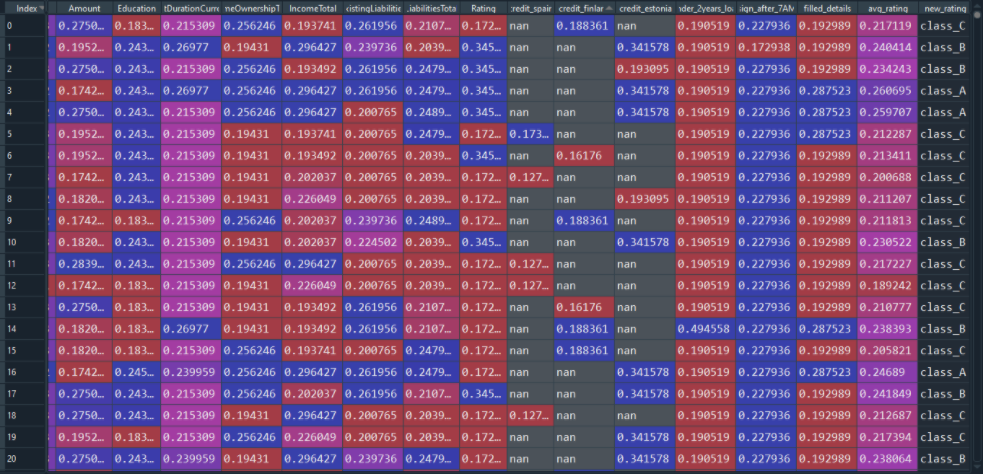

In [ ]:
class OurOneHotEncoder(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        super().__init__()
        self.cat_cols= ['Gender', 'Education', 'EmploymentDurationCurrentEmployer',
       'HomeOwnershipType', 'Rating', 'credit_spain', 'credit_finland',
       'credit_estonia', 'under_2years_loan', 'sign_after_7AM',
       'filled_details', 'Age', 'IncomeTotal', 'Amount', 'ExistingLiabilities',
       'LiabilitiesTotal', 'new_rating']
        
        self.hotcoder= ce.OneHotEncoder (cols=self.cat_cols, use_cat_names=True)
        
    def fit(self, X, y=None):
        self.hotcoder.fit(X)

        return self
    
    def transform(self, X):
        X_new= self.hotcoder.transform(X)
        self.x_new=X_new
        return X_new


explaining cross-validation with time series split:

the set was split to 4 parts by their index (ordered by date)
the left column in table below is the train set and the right is the test set
so in the first round the first part predicts on the 2, 3 and 4 parts and so on.
this assures the train always contains the "older" part of the set.

| train cv periods |  test cv periods|  |
| --- | --- | --- |
| 1 | 2+3+4 |  |
| 1+2 | 3+4|  |
| 1+2+3 | 4 |  |

In [ ]:
X_train= X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)

y_train_new =pd.Series(y_train_new )
y_test_new =pd.Series(y_test_new )

y_train_new= pd.Series(np.where(y_train_new.values== 'Repaid', 1, 0),
                       name='Status')
y_test_new= pd.Series(np.where(y_test_new.values== 'Repaid', 1, 0),
                      name='Status')
 
model1 =xgb.XGBClassifier()

model2 =CatBoostClassifier()

classifiers= [("xgb", model1), ("cbc", model2)]

from sklearn.ensemble import VotingClassifier

clf_voting= VotingClassifier(estimators=classifiers, voting='soft',
                             weights=None)

final_model =     \
Pipeline( steps= [  ("knn_imputer", KnnNullImputingSpainCredit() )
                   ,("cut", MyBinsEncoder() )
                   ,("rating", TargetRating(class_limit= 0.025) ) 
                   ,("ohe", OurOneHotEncoder())
                   ,("voter",clf_voting)] )
final_model    

In [ ]:
test=X_test.join(y_test_new)
train=X_train.join(y_train_new)

test['Status'].cumsum().plot()
train['Status'].cumsum().plot()

plt.title("cumsum plot of repaid loans")

the cumsum plot above shows steady accumulation of "repaid" loans alnog the timeline that was chosen.
but this is not so true for the last coronavirus-inflicted months of 2020 which were not taken into consideration here.

In [ ]:


params_store= final_model.get_params()

param_search = {
            'voter__cbc__bagging_temperature': [0.5],
            'voter__cbc__depth': [4],
            'voter__cbc__iterations': [100],
            'voter__cbc__l2_leaf_reg':[25],
            'voter__cbc__learning_rate': [0.05],
            'voter__cbc__sampling_frequency': ['PerTreeLevel'],
            'voter__cbc__leaf_estimation_method': ['Gradient'],
            'voter__cbc__random_strength': [0.8],
            'voter__cbc__feature_border_type': ['MaxLogSum'],
            'voter__cbc__max_ctr_complexity': [2],
            'voter__cbc__fold_len_multiplier': [2],
                "voter__xgb__learning_rate"    : [0.045] ,
                "voter__xgb__max_depth"        : [ 3],
                "voter__xgb__min_child_weight" : [ 5],
                "voter__xgb__gamma"            : [ 0.0],
                "voter__xgb__colsample_bytree" : [1] ,
                "voter__xgb__scale_pos_weight" : [1],
                "voter__xgb__n_estimators": [100]       }
    


scorers = {
    'precision_score': make_scorer(precision_score)}

tscv = TimeSeriesSplit(n_splits=3) # this return 3 arrays each for ever time split of the data
gsearch = GridSearchCV(estimator=final_model, cv=tscv, scoring=scorers,
                        refit='precision_score',  param_grid=param_search, verbose=0 ) #n_jobs=4

gsearch.fit(X_train, y_train_new);

y_test_pred= gsearch.best_estimator_.predict(X_test);



In [ ]:

cv_report= pd.DataFrame(gsearch.cv_results_) # gives accuracy score 

conf_matrix= confusion_matrix(y_test_new ,y_test_pred)


In [ ]:
pd.options.display.float_format = '{:,.5f}'.format
report= pd.DataFrame(classification_report(y_test_new ,y_test_pred ,output_dict=True))


report

In [ ]:
pd.DataFrame(conf_matrix)

In [ ]:
proba_test = gsearch.best_estimator_.predict_proba(X_test)[:,1]
proba_train= gsearch.best_estimator_.predict_proba(X_train)[:,1]

table= pd.DataFrame(y_test_new.to_numpy(), proba_test).reset_index() 
table.columns=['y_pred','y_original']
                                                            
table2= table[table['y_pred']>0.76]
              
print("probabilty for 'Repaid' status" ,table2['y_original'].sum()/len(table2))

print("number of loans: ",len(table2))

conclusion: 
1. we got mediocre precision and very poor recall for the "repaid" loans. so it seems that it's close to impossible to predict the "positive" human behaviour in Bondora site beyond some simple rules (your chances are much better when lending small amounts for short peirods of time for people from estonia but thats about it..) 

2. we get a very good prediction for the "LATE" loans. one might say it's not a difficult task when we have  about 80% "LATE" loans in the dataset, but still  the model managed to find alomost all of them, which might come in handy. 

3. this means you can avoid the bad loans easily, but the model can only find vey few loans that he predicts will be repaid. For bondora this is bad news because this means their rating scale is misleading and not usable, and even worse- there are vey few solid options for good invesment.  this "invetory" of solid investments  will run out very fast, and the inevitable failures should scare away the coservative investor.

4. for the sole lender that didn't run away-- it's good news. since one only needs few good loans to make a decent revenue.
   for example -if you want to maximize your precision ,you can reach up to 88%, 
   but this will only be true to around 120 loans. for one loaner it's seems enough.

5. So, to sum it up -- using training dataset of ~80,000 loans yielded  about 120 "sure bet" loans - this means that we are left with the problem of getting enough options from bondora to choose from in the first place which are still relevant for today's loaners.  coronavirus case  for instance can transform the training set to something obsolete..

another issue is the revenue you get from the loans. for better results, we had to tune down the expected revenue to close to zero when we relabeled the dataset. (for example,  even a loan that returned 0.001% interest was labeled "repaid").
so this means not all returns will be as good as you might expect and **surely** not as good as advertised..  but at least you got your money back and helped a person in need! (as long he is from estonia and needs **very** few euro's, anyways..).

-the end-

